# Particle physics results

## Setup

In [1]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import roc_auc_score

sys.path.append("../../")
from experiments.datasets import WBFLoader
import plot_settings as ps


In [2]:
ps.setup()

## Helper functions

In [3]:
def histo_w_err(
    xvals, xmin, xmax, nbins,
    ls="-", m=" ", ms=6., c="black",
    label=None, alpha=0.1,
    subtract_min=False, plot_individual=False,
    **kwargs
):
    # Calculate histograms
    histos = []
    for x in xvals:
        histo, bin_edges = np.histogram(x, bins=nbins, range=(xmin, xmax), density=True)
        histos.append(histo)
    histos = np.array(histos)

    # Mean and error band
    y_mean, y_err = np.nanmean(histos, axis=0), np.nanstd(histos, axis=0)
    
    x_ = np.repeat(bin_edges, 2)[1:-1]
    y_ = np.repeat(y_mean, 2)
    y_err_ = np.repeat(y_err, 2)
    yis_ = [np.repeat(y, 2) for y in histos]
    
    # Plot
    plt.fill_between(x_, y_ - y_err_, y_ + y_err_, color=c, alpha=alpha)
    plt.plot(x_, y_, label=label, ls=ls, marker=m, ms=ms, c=c, lw=1.5, **kwargs)
    
    if plot_individual:
        for yi_ in yis_:
            plt.plot(x_, yi_, ls=ls, lw=0.5, c=c)
    

## Load results

In [4]:
n_runs = 10
n_chains = 4
n_trueparams = 3
n_panels = 9

remove_all_results_with_nans = False

In [5]:
algo_filenames = []
algo_additionals = []
algo_labels = []
algo_colors = []
algo_markers = []
algo_linestyles = []
algo_dims = []
algo_panels = []
algo_best_runs = []

def add_algo(filename, add, label, c, m, ls, panel, best_run, dim=""):
    algo_filenames.append(filename)
    algo_additionals.append(add)
    algo_labels.append(label)
    algo_colors.append(c)
    algo_markers.append(m)
    algo_linestyles.append(ls)
    algo_dims.append(dim)
    algo_panels.append(panel)
    algo_best_runs.append(best_run)
    
    
add_algo("flow", "_june", "AF", ps.COLOR_AF, "o", "-", 0, 2, "40d")
add_algo("pie", "_conditionalmanifold_june", "PIE", ps.COLOR_PIE, "o", "-", 1, 3, "40d") 
add_algo("mf", "_june", r"$\mathcal{M}$-flow", ps.COLOR_FLMA, "o", "-", 2, 1, "40d")
add_algo("emf", "_june", r"$\mathcal{M}_e$-flow", ps.COLOR_FLMEA, "o", "-", 3, 0, "40d")

add_algo("flow", "_scandal_june", r"AF (S)", ps.COLOR_AF, "s", "--", 4, 2, "40d")
add_algo("pie", "_conditionalmanifold_scandal_june", r"PIE (S)", ps.COLOR_PIE, "s", "--", 5, 3, "40d") 
add_algo("mf", "_scandal_june", r"$\mathcal{M}$-flow (S)", ps.COLOR_FLMA, "s", "--", 6, 1, "40d")
add_algo("emf", "_scandal_june", r"$\mathcal{M}_e$-flow (S)", ps.COLOR_FLMEA, "s", "--", 7, 0, "40d")

add_algo("alices", "_may", "LR (A)", ps.COLOR_MADMINER, "o", "-", 8, 0)

n_algos = len(algo_filenames)

In [6]:
def load(name, shape, numpyfy=True, chains=1, result_dir="../data/results"):
    all_results = []
    
    for algo_filename, algo_add, algo_dim in zip(algo_filenames, algo_additionals, algo_dims):
        algo_results = []
            
        for run in range(n_runs):
            run_str = "" if run == 0 else "_run{}".format(run)
            
            for trueparam in range(n_trueparams):
                trueparam_str = "" if trueparam == 0 else "_trueparam{}".format(trueparam)

                try:
                    this_result = np.load(
                        "{}/{}_{}_lhc{}{}{}_{}{}.npy".format(
                            result_dir, algo_filename, "2" if algo_dim == "2d" else "14",
                            algo_dim, algo_add, run_str, name, trueparam_str
                        )
                    )
                    if (not numpyfy) or (shape is None) or np.product(this_result.shape) == np.product(shape):
                        algo_results.append(this_result.reshape(shape))
                    else:
                        algo_results.append(np.nan*np.ones(shape))

                except FileNotFoundError as e:
                    # print(e)
                    if shape is None:
                        algo_results.append(None)
                    else:
                        algo_results.append(np.nan*np.ones(shape))
            
        all_results.append(algo_results)
    
    if numpyfy:
        all_results = np.array(all_results, dtype=np.float)
        all_results = all_results.reshape([all_results.shape[0], n_runs, n_trueparams] + list(shape))
        
    return all_results


model_gen_x = load("samples", None, numpyfy=False)
model_gen_closure = load("samples_manifold_distance", (10000,))


In [7]:
def load_mcmc(name, shape, numpyfy=True, result_dir="../data/results"):
    all_results = []
    
    for algo_filename, algo_add, algo_dim in zip(algo_filenames, algo_additionals, algo_dims):
        algo_results = []
            
        for run in range(n_runs):
            run_str = "" if run == 0 else "_run{}".format(run)
            
            for trueparam in range(n_trueparams):
                trueparam_str = "" if trueparam == 0 else "_trueparam{}".format(trueparam)
            
                for chain in range(n_chains):
                    chain_str = "" if chain == 0 else "_chain{}".format(chain)

                    try:
                        this_result = np.load(
                            "{}/{}_{}_lhc{}{}{}_{}{}{}.npy".format(
                                result_dir, algo_filename, "2" if algo_dim == "2d" else "14",
                                algo_dim, algo_add, run_str, name, trueparam_str, chain_str
                            )
                        )
                        if (not numpyfy) or (shape is None) or np.product(this_result.shape) == np.product(shape):
                            algo_results.append(this_result.reshape(shape))
                        else:
                            algo_results.append(np.nan*np.ones(shape))

                    except FileNotFoundError as e:
                        # print(e)
                        if shape is None:
                            algo_results.append(None)
                        else:
                            algo_results.append(np.nan*np.ones(shape))
            
        all_results.append(algo_results)
    
    all_results = np.array(all_results, dtype=np.float)
    all_results = all_results.reshape([all_results.shape[0], n_runs, n_trueparams, n_chains] + list(shape))
        
    return all_results


model_posterior_samples = load_mcmc("posterior_samples", (2500, 2,))
model_posterior_samples.shape  # (algo, run, true param id, chain, sample, theta component)


(9, 10, 3, 4, 2500, 2)

In [8]:
sim = WBFLoader()

test_x, _ = sim.load_dataset(train=False, dataset_dir="../data/samples/lhc", numpy=True)

test_closure = sim.distance_from_manifold(test_x)

In [9]:
def remove_nans(*results):
    passes = all([np.all(np.isfinite(result)) for result in results])
    
    if passes:
        return results
    else:
        return [np.nan * np.ones_like(result) for result in results]


def remove_nans_from_lists(*raws):
    # raws[quantity][algo]
    n_quantities = len(raws)
    n_algos = len(raws[0])
    
    for raw in raws:
        assert len(raw) == n_algos
    
    cleans = [[[] for _ in range(n_algos)] for _ in range(n_quantities)]
    
    for i in range(n_algos):
        for k in range(n_runs):
            clean = remove_nans(*[raw[i][k] for raw in raws])
            for j in range(n_quantities):
                cleans[j][i].append(clean[j])
            
    cleans = [np.array(clean) for clean in cleans]
    
    # cleans[quantity][algo]
    return cleans
   
if remove_all_results_with_nans:
    raw = [model_gen_closure, model_posterior_samples]
    clean = remove_nans_from_lists(*raw)
    model_gen_closure, model_posterior_samples = clean


## Calculate metrics

In [10]:
n_observed = 100
min_logp = -100.

test_mean_closure = np.mean(test_closure, axis=-1)
model_gen_mean_closure = np.mean(model_gen_closure, axis=(2,3))


## Generative mode: closure test

/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.7/site-packages/numpy/lib

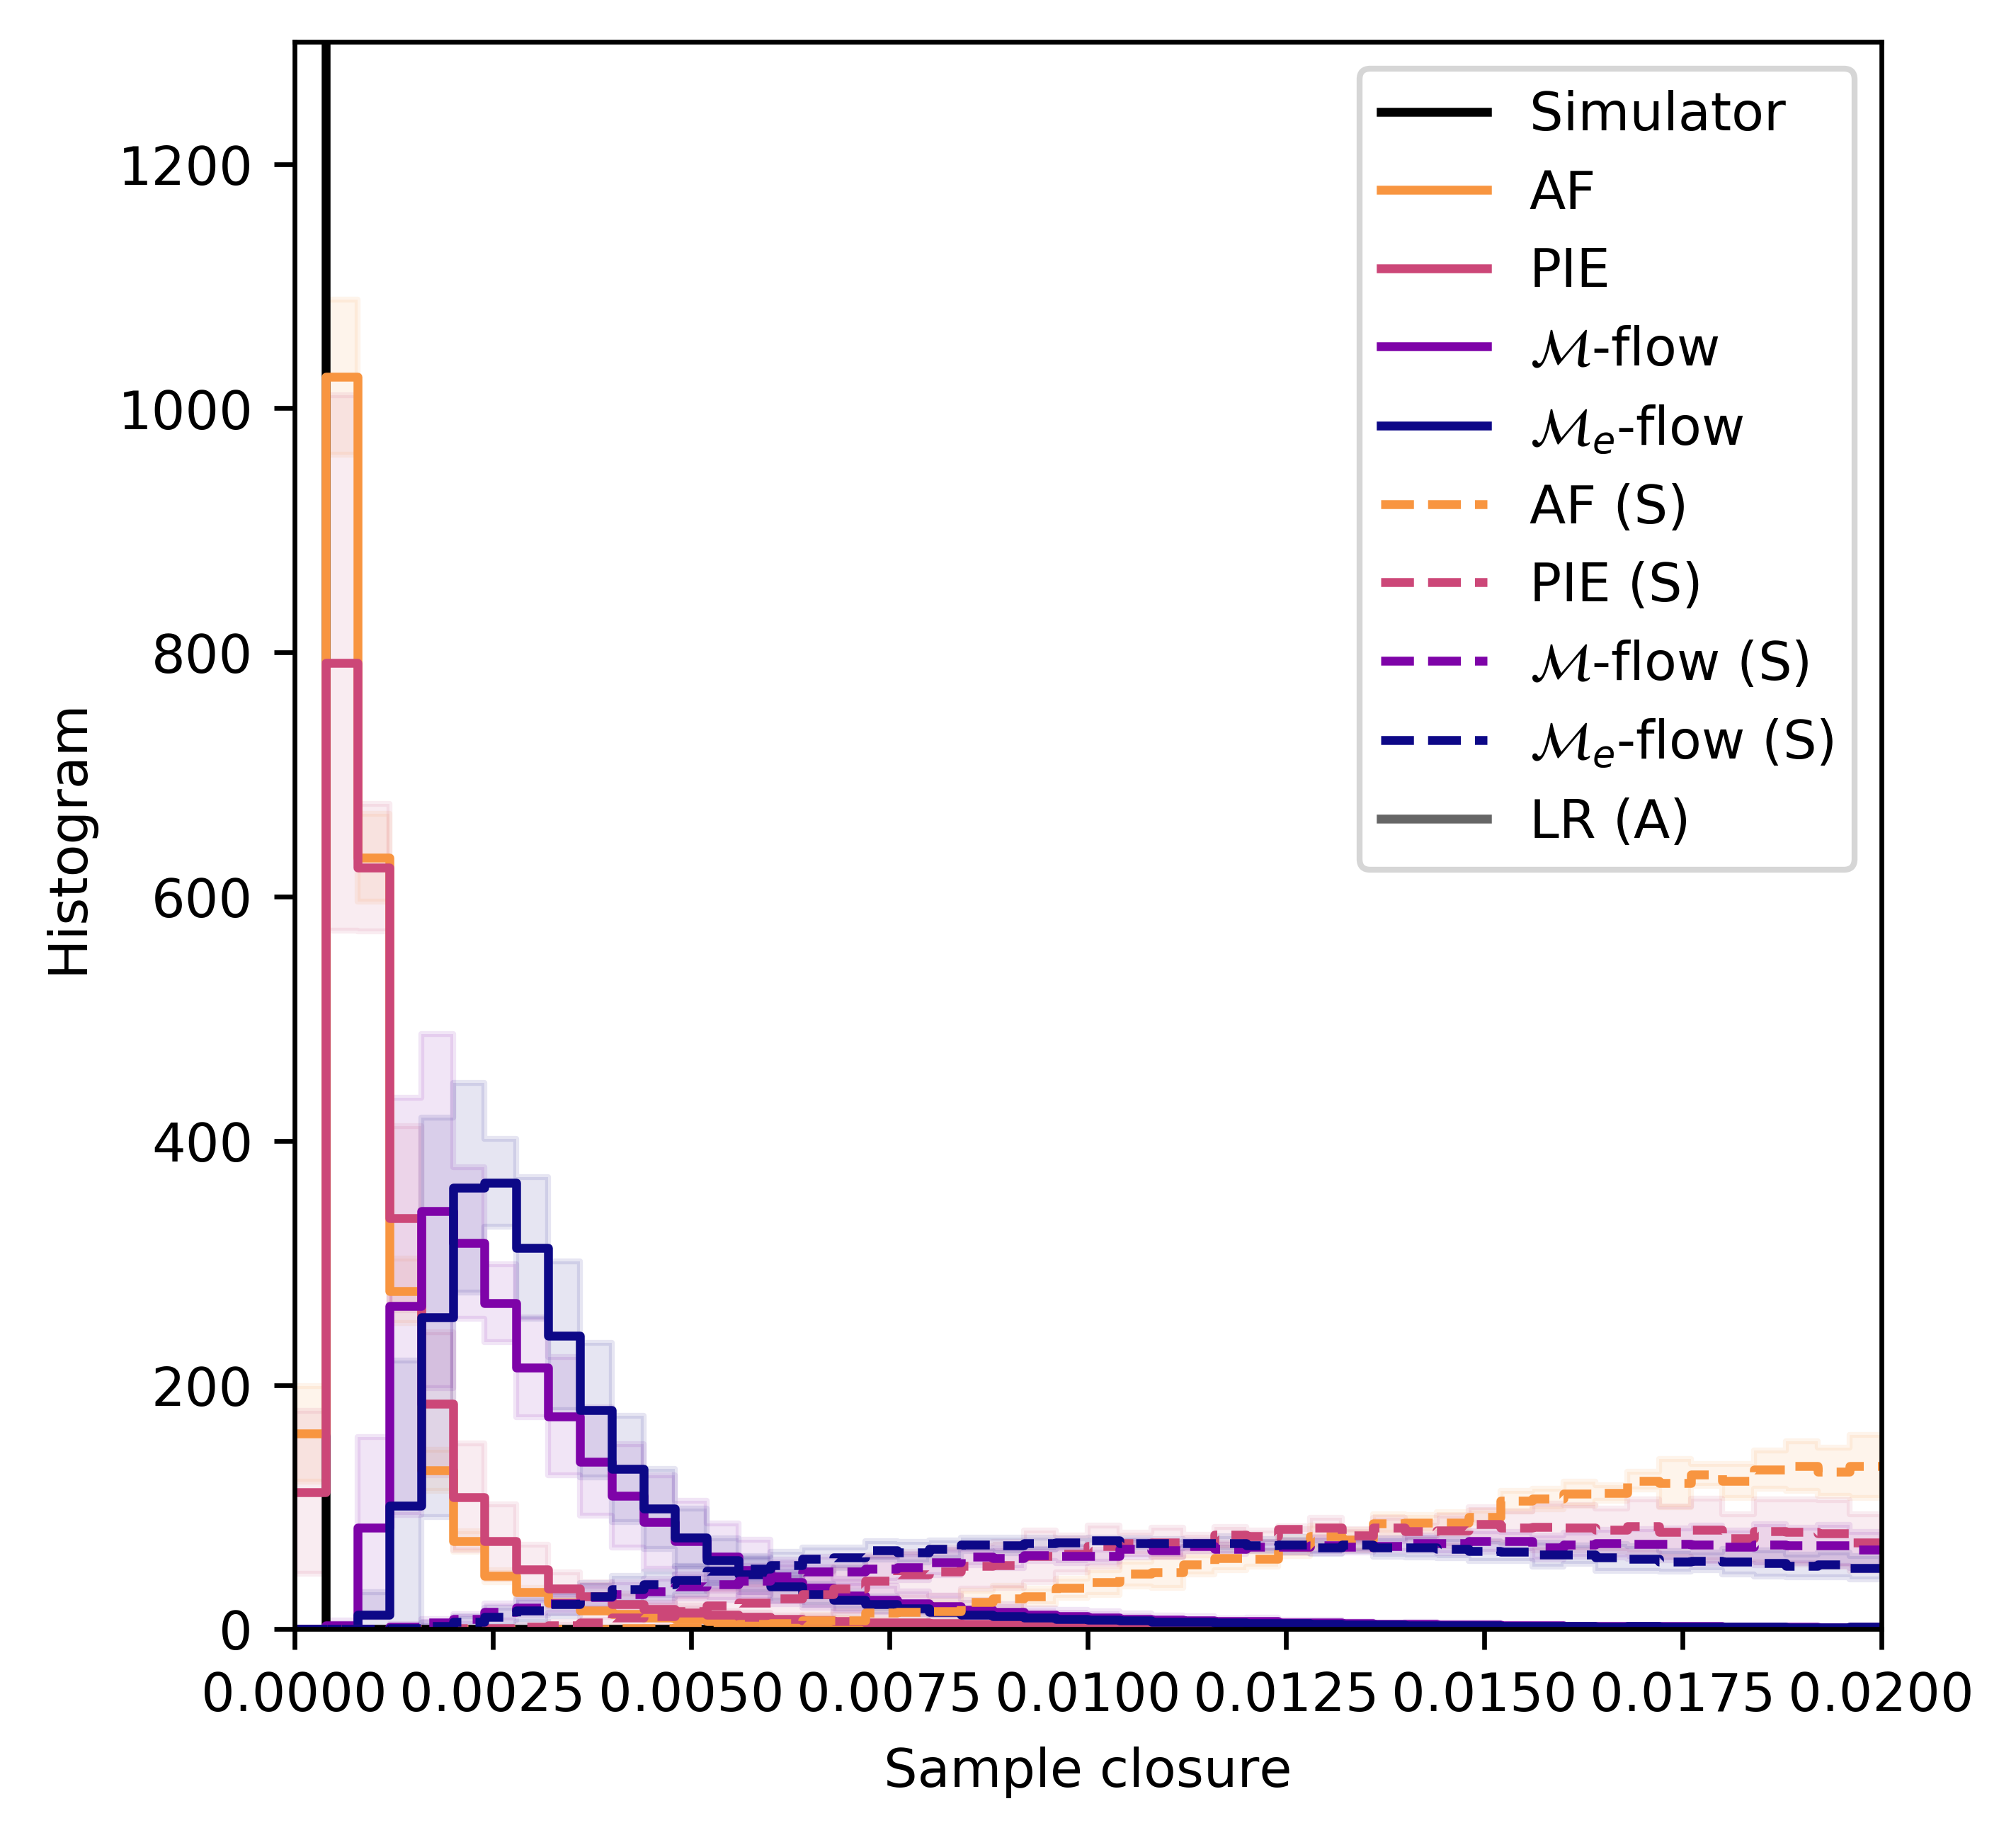

In [11]:
xmin, xmax = 0.,0.02
bins = 50

fig, ax = ps.figure()
    
histo_w_err(
    test_closure,
    xmin, xmax, bins,
    label="Simulator",
    c="black",
)

for closure, algo_label, c, m, ls in zip(model_gen_closure, algo_labels, algo_colors, algo_markers, algo_linestyles):
    histo_w_err(
        closure,
        xmin, xmax, bins,
        label=algo_label,
        c=c,
        ls=ls,
    )

plt.legend()

plt.xlabel(r"Sample closure")
plt.ylabel(r"Histogram")
plt.xlim(xmin, xmax)
plt.ylim(0., 1300.)
#plt.yscale("log")
#plt.ylim(1.e-2, 2.e2)

plt.savefig("../figures/lhc_generated_samples_closure.pdf")


## Posterior plots

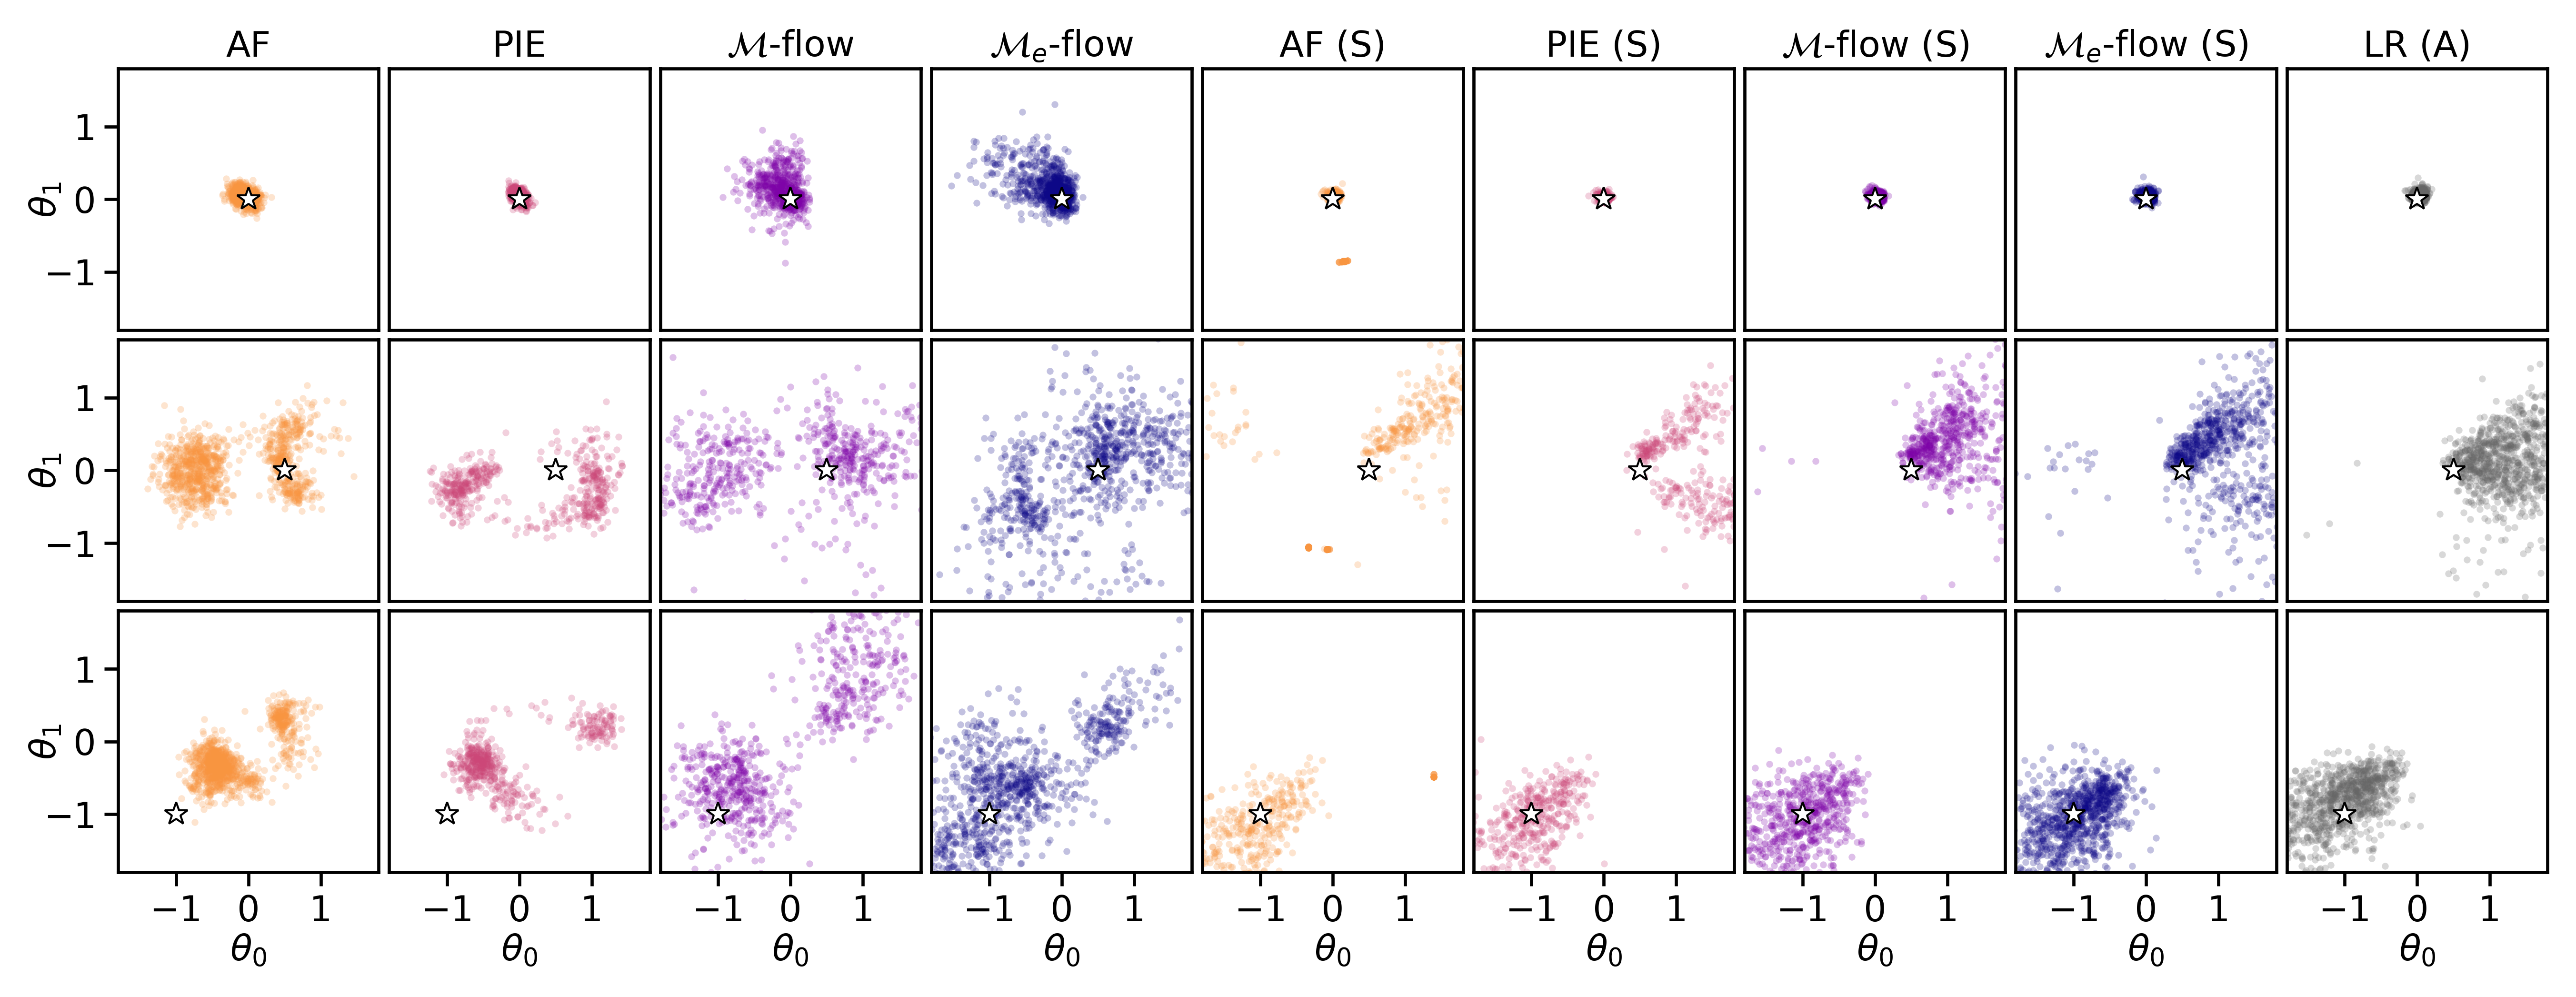

In [12]:
skip = 100
extent = 1.8

true_params = [[0.,0.], [0.5, 0.], [-1., -1.]]

fig, gs = ps.grid_width(n_panels, n_trueparams, width=ps.TEXTWIDTH, large_margin=0.1, small_margin=0.05, sep=0.01)

for i in range(n_panels):
    for j in range(n_trueparams):
        ax = plt.subplot(gs[j*n_panels + i])
    
        # True point
        plt.plot(
            [true_params[j][0]], [true_params[j][1]], ls = " ",
            marker="*", markersize=6., markerfacecolor=ps.COLOR_NEUTRAL4, zorder=5.,
            markeredgewidth=0.5, markeredgecolor=ps.COLOR_NEUTRAL1, alpha=1.
        )
        
        # Results
        for label, posteriors, c, m, panel, run  in zip(
            algo_labels, model_posterior_samples, algo_colors, algo_markers, algo_panels, algo_best_runs
        ):
            if panel < 0 or panel == i:
                plt.scatter(
                    posteriors[:,j,:,::skip, 0], posteriors[:,j,:,::skip, 1],
                    c=[c], marker="o", s=3., alpha=0.25, lw=0.
                )
                if j == 0:
                    plt.title(label, fontsize=ps.FONTSIZE, pad=3)

        plt.xlim(-extent, extent)
        plt.ylim(-extent, extent)
        if j == n_trueparams - 1:
            plt.xticks([-1., 0., 1.], None)
            ax.tick_params(axis='x', which='major', pad=2)
        else:
            plt.xticks([], [])
        if i == 0:
            plt.yticks([-1., 0., 1.], None)
            ax.tick_params(axis='y', which='major', pad=2)
        else:
            plt.yticks([], [])
        plt.xlabel(r"$\theta_0$" if j == n_trueparams - 1 else "", labelpad=1)
        plt.ylabel(r"$\theta_1$" if i == 0 else "", labelpad=-5)

plt.savefig("../figures/lhc_posterior_scatter.pdf")
